In [1]:
# Install key dependencies
!pip install transformers[torch] datasets scikit-learn pandas tqdm biobert-embedding

# NLTK downloads
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Standard libraries
import os
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# NLP tools
from nltk.tokenize import sent_tokenize, word_tokenize
!pip install rake-nltk
from rake_nltk import Rake
!pip install rank_bm25
from rank_bm25 import BM25Okapi

# Transformers and sentence embeddings
from transformers import BertTokenizer, BertForQuestionAnswering
from sentence_transformers import SentenceTransformer, InputExample, losses

# Torch and data loading
import torch
from torch.utils.data import DataLoader

# Metrics
from sklearn.metrics import precision_score, recall_score, f1_score

!pip install faiss-cpu
# FAISS
import faiss

# Progress bars
from tqdm import tqdm

  Using cached biobert-embedding-0.1.2.tar.gz (4.8 kB)
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of biobert-embedding to determine which version is compatible with other requirements. This could take a while.
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.51.2-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.51.1-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.51.0-py3-none-any.whl.metadata (38 kB)
  Using cached transformers-4.50.3-py3-none-any.whl.metadata (39 kB)
  Using cached transformers-4.50.2-py3-none-any.whl.metadata (39 kB)
  Using cached transformers-4.50.1-py3-none-any.whl.metadata (39 kB)
INFO: pip is still looking at multiple versions of biobert-embedding to determine which version is compatible with other requirements. This could take a while.
  Using cached transformers-4.50.0-py3-none-any.whl.metadata (39 kB)
  Using cached transformers-4.49.0-py3

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
fake_article = """
WHY SLEEP MATTERS 💡

Sleep is not just rest^1—it's a critical biological function. (1) Every night, your brain and body engage in vital repair processes. Short subtitle: SLEEP STAGES.

There are four main stages of sleep: N1, N2, N3, and REM. Each stage plays a unique role in cognitive function and memory consolidation. [2] “Missing out on deep sleep can affect how your brain stores memories,” says Dr. Luna Moon, a neurologist at BrainHealth Org. 🧠

Quick facts:
- 35% of adults report poor sleep
- REM sleep is when dreams occur
- Sleep deprivation impairs judgment

Interview with Dr. Luna Moon:
Q: What’s the #1 mistake people make about sleep?
A: They treat it like a luxury. It’s a necessity—like food or water.

🌟 ADVERTISEMENT: Try DreamEase pillows—engineered with NASA technology! Use code SLEEP2024 for 20% off.

Studies also show a strong connection between sleep quality and emotional regulation. Poor sleep increases risks of depression and anxiety. Researchers from the Sleep Science Institute^2 note that even a single night of bad sleep can elevate cortisol levels, impacting your mood for days. “Sleep is your emotional reset button,” Dr. Moon adds.

References:
1. Smith, J. (2020). Sleep and Brain Health. Sleep Journal.
2. Sleep Science Institute Annual Report, 2021.

About the Author:
Chris Napper is a freelance health writer with over 15 years of experience writing about wellness, nutrition, and sleep science.

(END)
"""

In [3]:
df = pd.DataFrame({'text': [fake_article]})

In [4]:
import nltk

# Download the 'punkt' and 'punkt_tab' resources
nltk.download('punkt')
nltk.download('punkt_tab')
def is_relevant(text):
    # Basic filter for irrelevant articles (customize as needed)
    text_lower = text.lower()
    return any(keyword in text_lower for keyword in ["sleep", "night", "dream"])

def clean_text(text):
    # Remove footnotes and superscripts (e.g., [1], (1), etc.)
    text = re.sub(r"\[\d+\]", "", text)
    text = re.sub(r"\(\d+\)", "", text)

    # Remove author bios and references sections
    text = re.split(r"(?i)(references|about the author|bibliography)", text)[0]

    # Remove extra symbols and unnecessary punctuation
    text = re.sub(r"[^a-zA-Z0-9\s.,!?'-]", " ", text)  # Keep only basic punctuation
    text = re.sub(r"\s+", " ", text).strip()

    return text

def filter_sentences(sentences):
    # Remove duplicates and very short sentences (<5 words)
    seen = set()
    filtered = []
    for s in sentences:
        if len(word_tokenize(s)) >= 5:
            s_clean = s.strip()
            if s_clean not in seen:
                seen.add(s_clean)
                filtered.append(s_clean)
    return filtered

def chunk_into_passages(sentences, min_words=100, max_words=150):
    passages = []
    current = []
    count = 0
    for sent in sentences:
        words = word_tokenize(sent)
        current += words
        count += len(words)
        if count >= min_words:
            if count <= max_words or len(current) > max_words:
                passages.append(" ".join(current))
                current = []
                count = 0
    if current:
        passages.append(" ".join(current))  # Add remaining words
    return passages


rake = Rake()

def generate_title_with_keywords(text):
    rake.extract_keywords_from_text(text)
    keywords = rake.get_ranked_phrases()
    return keywords[0].title() if keywords else "Untitled"




all_passages = []

for idx, row in df.iterrows():
    text = row["text"]

    if not is_relevant(text):
      print(1)
      continue  # Skip irrelevant articles

    cleaned = clean_text(text)
    sentences = sent_tokenize(cleaned)
    filtered_sentences = filter_sentences(sentences)
    passages = chunk_into_passages(filtered_sentences)

    all_passages.extend(passages)
print("Total passages:", len(all_passages))
# Convert to DataFrame
corpus_df = pd.DataFrame({"passage": all_passages})
corpus_df["index"] = corpus_df.index
corpus_df["title"] = corpus_df["passage"].apply(generate_title_with_keywords)
corpus_df = corpus_df[["index", "passage", "title"]]

print("Total clean passages:", len(corpus_df))
print(corpus_df.head())

Total passages: 2
Total clean passages: 2
   index                                            passage  \
0      0  WHY SLEEP MATTERS Sleep is not just rest 1 it ...   
1      1  A They treat it like a luxury . It s a necessi...   

                                            title  
0    Sleep Deprivation Impairs Judgment Interview  
1  Advertisement Try Dreamease Pillows Engineered  


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# Clone the SleepQA repo
!git clone https://github.com/IvaBojic/SleepQA.git
%cd SleepQA

fatal: destination path 'SleepQA' already exists and is not an empty directory.
/content/SleepQA


In [6]:
# 1. Load data
corpus = pd.read_csv("data/training/sleep-corpus.tsv", sep="\t", header=None)
corpus.columns = ['index', 'passage', 'title']
test_qs = pd.read_csv("data/training/sleep-test.csv", sep="\t", header=None)
test_qs.columns = ['question', 'answer']

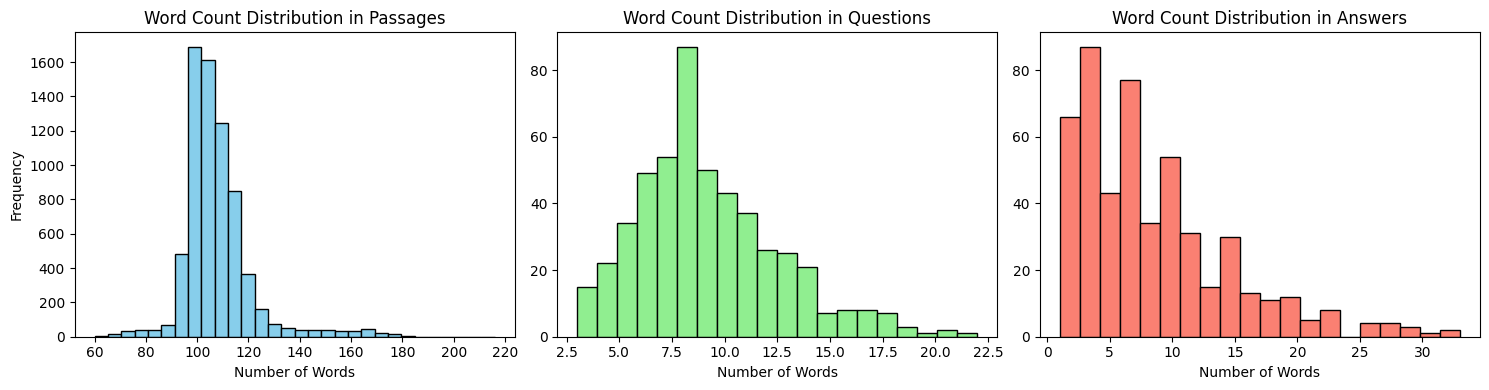

In [7]:
# Word count for passages
corpus['word_count'] = corpus['passage'].apply(lambda x: len(str(x).split()))

# Word count for questions and answers
test_qs['question_word_count'] = test_qs['question'].apply(lambda x: len(str(x).split()))
test_qs['answer_word_count'] = test_qs['answer'].apply(lambda x: len(str(x).split()))

# Plot for passages
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(corpus['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Word Count Distribution in Passages')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Plot for questions
plt.subplot(1, 3, 2)
plt.hist(test_qs['question_word_count'], bins=20, color='lightgreen', edgecolor='black')
plt.title('Word Count Distribution in Questions')
plt.xlabel('Number of Words')

# Plot for answers
plt.subplot(1, 3, 3)
plt.hist(test_qs['answer_word_count'], bins=20, color='salmon', edgecolor='black')
plt.title('Word Count Distribution in Answers')
plt.xlabel('Number of Words')

plt.tight_layout()
plt.show()


In [8]:
# Clone the SleepQA repo
!git clone https://github.com/IvaBojic/SleepQA.git
%cd SleepQA

# Install key dependencies
!pip install transformers faiss-cpu datasets scikit-learn pandas tqdm


fatal: destination path 'SleepQA' already exists and is not an empty directory.
/content/SleepQA/SleepQA


In [9]:
!pip install transformers faiss-cpu datasets scikit-learn pandas tqdm
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import faiss
import numpy as np
import time
import torch
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt  # Add at the top if not already
from transformers import BertTokenizer, BertForQuestionAnswering

# 1. Load data
corpus = pd.read_csv("data/training/sleep-corpus.tsv", sep="\t", header=None)
corpus.columns = ['index', 'passage', 'title']
test_qs = pd.read_csv("data/training/sleep-test.csv", sep="\t", header=None)
test_qs.columns = ['question', 'answer']

# 2. Setup models
models = {
    "BERT-SQuAD2": "deepset/bert-base-cased-squad2",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.1",
    "BioBERT-BioASQ": "ktrapeznikov/biobert_v1.1_pubmed_squad_v2",
    "PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract",
    "SciBERT": "allenai/scibert_scivocab_uncased",
    "ClinicalBERT": "emilyalsentzer/Bio_ClinicalBERT"
}

# 3. Prepare training examples
train_examples = [
    InputExample(texts=[row["question"], row["answer"]], label=1.0)
    for _, row in test_qs.iterrows()
]

# 4. Set hyperparameters
EPOCHS = 30
BATCH_SIZE = 16
LEARNING_RATE = 2e-5  # (cannot be directly set in SentenceTransformer.fit)

# Track compute
total_gpu_time = 0
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Hardware: Using {'GPU' if device == 'cuda' else 'CPU'}")

# 5. Define FAISS search
def query_faiss(question, model, top_k=3):
    q_emb = model.encode([question], convert_to_numpy=True)
    D, I = index.search(q_emb, top_k)
    return [answer_texts[i] for i in I[0]], D[0]

# 6. Define evaluation metrics
def evaluate_model(model, test_df, ks=[1]):
    results = {}

    for k in ks:
        recall_at_k = []
        exact_match = []
        f1_scores = []

        for _, row in test_df.iterrows():
            question = row["question"]
            true_answer = row["answer"]

            retrieved_passages, _ = query_faiss(question, model, top_k=k)

            # Recall@k: if true answer appears in any retrieved passage
            match_found = any(true_answer.strip().lower() in passage.lower() for passage in retrieved_passages)
            recall_at_k.append(1 if match_found else 0)

            # Exact Match
            em = any(true_answer.strip().lower() == passage.strip().lower() for passage in retrieved_passages)
            exact_match.append(1 if em else 0)

            # F1 score (token level) with best candidate
            best_f1 = 0
            for passage in retrieved_passages:
                true_tokens = set(true_answer.lower().split())
                pred_tokens = set(passage.lower().split())
                common = true_tokens & pred_tokens
                if not common:
                    continue
                precision = len(common) / len(pred_tokens)
                recall = len(common) / len(true_tokens)
                f1 = 2 * precision * recall / (precision + recall)
                best_f1 = max(best_f1, f1)
            f1_scores.append(best_f1)

        # Store results for each k
        results[k] = {
            "Recall@k": np.mean(recall_at_k),
            "Exact Match": np.mean(exact_match),
            "F1 Score": np.mean(f1_scores)
        }

    return results

# 7. Train and evaluate each model
for model_name, model_id in models.items():
    print(f"\n### Training Model: {model_name} ###")

    model = SentenceTransformer(model_id, device=device)
    train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=BATCH_SIZE)
    train_loss = losses.CosineSimilarityLoss(model)

    start_time = time.time()
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        epochs=EPOCHS,
        warmup_steps=10,
        show_progress_bar=True
    )
    end_time = time.time()

    epoch_time = (end_time - start_time) / EPOCHS
    total_gpu_time += (end_time - start_time)

    print(f"Training time: {end_time - start_time:.2f}s total | {epoch_time:.2f}s per epoch")

    # Compute embeddings
    answer_texts = test_qs["answer"].tolist()
    answer_embeddings = model.encode(answer_texts, convert_to_numpy=True, show_progress_bar=True)
    index = faiss.IndexFlatL2(answer_embeddings.shape[1])
    index.add(answer_embeddings)


    # Show top-3 results for first question
    sample_question = test_qs.iloc[0]["question"]
    results, distances = query_faiss(sample_question, model, top_k=3)

    print("\nTop-3 Similar Passages:")
    for i, (text, dist) in enumerate(zip(results, distances)):
        print(f"Rank {i+1}: {text[:100]}... (Distance: {dist:.4f})")

    # Save model
    os.makedirs("saved_models", exist_ok=True)
    model_save_path = f"saved_models/{model_name.replace(' ', '_')}"
    model.save(model_save_path)
    print(f"Model saved to: {model_save_path}")

    # Evaluate model

    # Initialize metrics dictionary
    if 'all_metrics' not in locals():
        all_metrics = {}

    # Evaluate model
    metrics = evaluate_model(model, test_qs, ks=[1,20,40,60,80,100])
    all_metrics[model_name] = metrics

    print(f"\nEvaluation Metrics for {model_name}:")
    for k, metrics_at_k in metrics.items():
        print(f"- k={k}:")
        for metric_name, value in metrics_at_k.items():
            print(f"    {metric_name}: {value:.4f}")  # Format the value to 4 decimal places


# 8. Final report
print("\n=================== Training Summary ===================")
print(f"Hyperparameters Used:")
print(f"- Learning Rate: {LEARNING_RATE} (default for transformers)")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Epochs: {EPOCHS}")
print(f"\nComputational Requirements:")
print(f"- Hardware: {'GPU' if device == 'cuda' else 'CPU'}")
print(f"- Models Trained: {len(models)}")
print(f"- Average Epoch Time (last model): {epoch_time:.2f}s")
print(f"- Total GPU Time: {total_gpu_time/3600:.2f} GPU hours")
print(f"\nTraining Details:")
print(f"- Loss Function: CosineSimilarityLoss")


Hardware: Using GPU

### Training Model: BERT-SQuAD2 ###


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: fairiesrock7 (fairiesrock7-zero2one-uiuc) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.000500


Training time: 244.50s total | 8.15s per epoch


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Top-3 Similar Passages:
Rank 1: ["taking steps to improve their sleep hygiene"]... (Distance: 0.3964)
Rank 2: ["by affecting levels of adenosine, a substance that helps regulate sleep"]... (Distance: 0.3967)
Rank 3: ["the use of an electronic device to help patients learn to control functions of the body"]... (Distance: 0.4014)
Model saved to: saved_models/BERT-SQuAD2



Evaluation Metrics for BERT-SQuAD2:
- k=1:
    Recall@k: 0.0620
    Exact Match: 0.0620
    F1 Score: 0.0993
- k=20:
    Recall@k: 0.2280
    Exact Match: 0.2280
    F1 Score: 0.3560
- k=40:
    Recall@k: 0.3120
    Exact Match: 0.3120
    F1 Score: 0.4502
- k=60:
    Recall@k: 0.3960
    Exact Match: 0.3960
    F1 Score: 0.5233
- k=80:
    Recall@k: 0.4500
    Exact Match: 0.4500
    F1 Score: 0.5713
- k=100:
    Recall@k: 0.5020
    Exact Match: 0.5020
    F1 Score: 0.6152

### Training Model: BioBERT ###


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.000400


Training time: 184.26s total | 6.14s per epoch


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Top-3 Similar Passages:
Rank 1: ["it can make you more vulnerable to respiratory illness"]... (Distance: 0.1013)
Rank 2: ["regular listening may be more effective at improving sleep quality"]... (Distance: 0.1093)
Rank 3: ["someone who feels foggy and tired"]... (Distance: 0.1127)
Model saved to: saved_models/BioBERT



Evaluation Metrics for BioBERT:
- k=1:
    Recall@k: 0.0420
    Exact Match: 0.0420
    F1 Score: 0.0806
- k=20:
    Recall@k: 0.1460
    Exact Match: 0.1460
    F1 Score: 0.2851
- k=40:
    Recall@k: 0.2120
    Exact Match: 0.2120
    F1 Score: 0.3621
- k=60:
    Recall@k: 0.2600
    Exact Match: 0.2600
    F1 Score: 0.4086
- k=80:
    Recall@k: 0.3160
    Exact Match: 0.3160
    F1 Score: 0.4582
- k=100:
    Recall@k: 0.3440
    Exact Match: 0.3440
    F1 Score: 0.4846

### Training Model: BioBERT-BioASQ ###


config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.001000


Training time: 184.86s total | 6.16s per epoch


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Top-3 Similar Passages:
Rank 1: ["to keep a journal with notes about how well and how long you sleep each night"]... (Distance: 0.4161)
Rank 2: ["takes a long time to change shape under pressure"]... (Distance: 0.4217)
Rank 3: ["create a new bedtime song for your kids"]... (Distance: 0.4248)
Model saved to: saved_models/BioBERT-BioASQ

Evaluation Metrics for BioBERT-BioASQ:
- k=1:
    Recall@k: 0.0540
    Exact Match: 0.0540
    F1 Score: 0.0981
- k=20:
    Recall@k: 0.2120
    Exact Match: 0.2120
    F1 Score: 0.3434
- k=40:
    Recall@k: 0.2780
    Exact Match: 0.2780
    F1 Score: 0.4148
- k=60:
    Recall@k: 0.3740
    Exact Match: 0.3740
    F1 Score: 0.4988
- k=80:
    Recall@k: 0.4280
    Exact Match: 0.4280
    F1 Score: 0.5464
- k=100:
    Recall@k: 0.4620
    Exact Match: 0.4620
    F1 Score: 0.5750

### Training Model: PubMedBERT ###


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.000100


Training time: 180.77s total | 6.03s per epoch


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Top-3 Similar Passages:
Rank 1: ["situations that could trigger heightened worry"]... (Distance: 2.4295)
Rank 2: ["progress for someone who already has a diagnosis of night eating syndrome"]... (Distance: 2.5958)
Rank 3: ["healthy sleep habits, as children learn through parent modeling"]... (Distance: 2.7451)
Model saved to: saved_models/PubMedBERT



Evaluation Metrics for PubMedBERT:
- k=1:
    Recall@k: 0.0440
    Exact Match: 0.0440
    F1 Score: 0.0789
- k=20:
    Recall@k: 0.1840
    Exact Match: 0.1840
    F1 Score: 0.3075
- k=40:
    Recall@k: 0.2580
    Exact Match: 0.2580
    F1 Score: 0.3920
- k=60:
    Recall@k: 0.3220
    Exact Match: 0.3220
    F1 Score: 0.4553
- k=80:
    Recall@k: 0.3780
    Exact Match: 0.3780
    F1 Score: 0.5090
- k=100:
    Recall@k: 0.4220
    Exact Match: 0.4220
    F1 Score: 0.5477

### Training Model: SciBERT ###


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.001100


Training time: 184.64s total | 6.15s per epoch


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Top-3 Similar Passages:
Rank 1: ["worsen the symptoms and severity of dementia"]... (Distance: 0.6256)
Rank 2: ["to reduce the risk of complications"]... (Distance: 0.6283)
Rank 3: ["by affecting levels of adenosine, a substance that helps regulate sleep"]... (Distance: 0.6531)
Model saved to: saved_models/SciBERT



Evaluation Metrics for SciBERT:
- k=1:
    Recall@k: 0.0360
    Exact Match: 0.0360
    F1 Score: 0.0774
- k=20:
    Recall@k: 0.1480
    Exact Match: 0.1480
    F1 Score: 0.2788
- k=40:
    Recall@k: 0.2260
    Exact Match: 0.2260
    F1 Score: 0.3698
- k=60:
    Recall@k: 0.2800
    Exact Match: 0.2800
    F1 Score: 0.4212
- k=80:
    Recall@k: 0.3180
    Exact Match: 0.3180
    F1 Score: 0.4583
- k=100:
    Recall@k: 0.3620
    Exact Match: 0.3620
    F1 Score: 0.4990

### Training Model: ClinicalBERT ###


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.000400


Training time: 185.16s total | 6.17s per epoch


Batches:   0%|          | 0/16 [00:00<?, ?it/s]


Top-3 Similar Passages:
Rank 1: ["the amount of time adults spent in different sleep stages"]... (Distance: 0.1247)
Rank 2: ["hormones that help control appetite and hunger"]... (Distance: 0.1307)
Rank 3: ["anyone who wants extra space for storage"]... (Distance: 0.1415)
Model saved to: saved_models/ClinicalBERT

Evaluation Metrics for ClinicalBERT:
- k=1:
    Recall@k: 0.0300
    Exact Match: 0.0300
    F1 Score: 0.0649
- k=20:
    Recall@k: 0.1460
    Exact Match: 0.1460
    F1 Score: 0.2813
- k=40:
    Recall@k: 0.2040
    Exact Match: 0.2040
    F1 Score: 0.3525
- k=60:
    Recall@k: 0.2420
    Exact Match: 0.2420
    F1 Score: 0.3892
- k=80:
    Recall@k: 0.2920
    Exact Match: 0.2920
    F1 Score: 0.4342
- k=100:
    Recall@k: 0.3400
    Exact Match: 0.3400
    F1 Score: 0.4820

=================== Training Summary ===================
Hyperparameters Used:
- Learning Rate: 2e-05 (default for transformers)
- Batch Size: 16
- Epochs: 30

Computational Requirements:
- Hardware: GP

In [1]:
# Evaluate model
#from sentence_transformers import SentenceTransformer

# Load the saved model from the specified path
#model = SentenceTransformer("saved_models/PubMedBERT")

# Now you can use the model for encoding, querying, etc.

#metrics = evaluate_model(model, test_qs, ks=[1,20,40,60,80,100])
#all_metrics[model_name] = metrics

#print(f"\nEvaluation Metrics for {model_name}:")
#print(f"\nEvaluation Metrics for {model_name}:")
#for k, metrics_at_k in metrics.items():
    #print(f"- k={k}:")
    #for metric_name, value in metrics_at_k.items():
        #print(f"    {metric_name}: {value:.4f}")  # Format the value to 4 decimal places
# 8. Final report
#print("\n=================== Training Summary ===================")
#print(f"Hyperparameters Used:")
#print(f"- Learning Rate: {LEARNING_RATE} (default for transformers)")
#print(f"- Batch Size: {BATCH_SIZE}")
#print(f"- Epochs: {EPOCHS}")
#print(f"\nComputational Requirements:")
#print(f"- Hardware: {'GPU' if device == 'cuda' else 'CPU'}")
#print(f"- Models Trained: {len(models)}")
#print(f"- Average Epoch Time (last model): {epoch_time:.2f}s")
#print(f"- Total GPU Time: {total_gpu_time/3600:.2f} GPU hours")
#print(f"\nTraining Details:")
#print(f"- Loss Function: CosineSimilarityLoss")



In [11]:
# 1. Load data
corpus = pd.read_csv("data/training/sleep-corpus.tsv", sep="\t", header=None)
corpus.columns = ['index', 'passage', 'title']
test_qs = pd.read_csv("data/training/sleep-test.csv", sep="\t", header=None)
test_qs.columns = ['question', 'answer']
test_qs

tokenized_corpus = [doc.split(" ") for doc in corpus["passage"]]  # Tokenize for BM25
print(tokenized_corpus[:1])

# Create BM25 model
bm25 = BM25Okapi(tokenized_corpus)

# Define query_bm25 function
def query_bm25(query, bm25_model, top_k=5):
    tokenized_query = query.split(" ")
    scores = bm25_model.get_scores(tokenized_query)
    top_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_k]
    top_passages = corpus.iloc[top_indices]
    return top_passages, [scores[i] for i in top_indices]
query = "who has an enviable life?"
passages, top_scores = query_bm25(query, bm25, top_k=3)

# Output the results
print("Top Passages:")
print(passages)
print("\nBM25 Scores:")
print(top_scores)
#answer = answer_bert_batched(query, passages, bert_tokenizer, bert_model, batch_size=16)

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
EPOCHS = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load fine-tuned BERT model and tokenizer (SQuAD2.0)
bert_tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1-squad')
bert_model = BertForQuestionAnswering.from_pretrained('dmis-lab/biobert-base-cased-v1.1-squad').to(device)

# Function to handle BERT predictions with BM25 passage retrieval and batching
def answer_bert_batched(question, bm25, tokenizer, model, top_k=100, batch_size=16):
    # Retrieve top-k passages using BM25
    passages, scores = query_bm25(question, bm25, top_k=top_k)

    all_inputs = []
    for passage in passages:
        inputs = tokenizer.encode_plus(
            question, passage,
            add_special_tokens=True,
            return_tensors="pt",
            padding=False
        )
        all_inputs.append(inputs)

    all_answers = []
    for i in range(0, len(all_inputs), batch_size):
        batch_inputs = all_inputs[i:i + batch_size]

        input_ids = torch.nn.utils.rnn.pad_sequence(
            [x["input_ids"].squeeze(0) for x in batch_inputs],
            batch_first=True
        ).to(device)
        attention_mask = torch.nn.utils.rnn.pad_sequence(
            [x["attention_mask"].squeeze(0) for x in batch_inputs],
            batch_first=True
        ).to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            start_scores, end_scores = outputs.start_logits, outputs.end_logits

        for idx in range(input_ids.size(0)):
            start_idx = torch.argmax(start_scores[idx]).item()
            end_idx = torch.argmax(end_scores[idx]).item()

            if start_idx <= end_idx:
                answer_tokens = input_ids[idx][start_idx:end_idx + 1]
                answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(answer_tokens))
            else:
                answer = ""

            if answer.strip() == "[CLS]" or not answer.strip():
                answer = ""

            all_answers.append(answer)

    return all_answers[0] if all_answers else ""

# Evaluation function with BM25 + BERT pipeline
def evaluate_pipeline_with_k_values(pipeline_id, bm25, ks=[1, 20, 40, 60, 80, 100]):
    results = {}

    for k in ks:
        all_answers = []
        y_true = []
        y_pred = []

        print(f"\nEvaluating Pipeline {pipeline_id} with top_k={k}...")

        for idx, row in tqdm(test_qs.iterrows(), total=len(test_qs), desc=f"top_k={k}"):
            question = row["question"]
            true_answer = row["answer"]

            if pipeline_id == 1:
                answer = answer_bert_batched(question, bm25, bert_tokenizer, bert_model, top_k=k, batch_size=BATCH_SIZE)

            all_answers.append((answer, true_answer))
            y_true.append(true_answer)
            y_pred.append(answer)

        # Compute metrics
        exact_match = sum([1 if a[0].strip().lower() == a[1].strip().lower() else 0 for a in all_answers])
        precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
        recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

        results[k] = {
            "Exact Match": exact_match / len(all_answers),
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1
        }

    return results

# Run evaluation
pipeline_1_metrics_by_k = evaluate_pipeline_with_k_values(1, bm25, ks=[1, 20, 40, 60, 80, 100])

# Print results
print("\n=================== Evaluation by Top-K ===================")
for k, metrics in pipeline_1_metrics_by_k.items():
    print(f"\nk = {k}")
    for metric_name, value in metrics.items():
        print(f"- {metric_name}: {value:.4f}")

# Summary
print("\n=================== Training Summary ===================")
print(f"Hyperparameters Used:")
print(f"- Learning Rate: {LEARNING_RATE}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Epochs: {EPOCHS}")
print(f"\nComputational Requirements:")
print(f"- Hardware: {'GPU' if device == 'cuda' else 'CPU'}")
print(f"- Models Trained: 1 (BERT-based model)")

print("\n=================== Average Evaluation Metrics ===================")
for k, metrics in pipeline_1_metrics_by_k.items():
    print(f"\nTop-K = {k}")
    for metric_name, value in metrics.items():
        print(f"- {metric_name}: {value:.4f}")


[['when', 'thinking', 'about', 'sleep', 'and', 'its', 'relationship', 'to', 'the', 'senses,', 'few', 'people', 'immediately', 'think', 'of', 'smell.', 'sight,', 'sound,', 'and', 'touch', 'typically', 'receive', 'more', 'attention', 'because', 'of', 'the', 'obvious', 'ways', 'that', 'light,', 'noise,', 'and', 'comfort', 'can', 'impact', 'sleep.', 'while', 'it', 'might', 'not', 'be', 'as', 'immediately', 'apparent,', 'smell', 'can', 'directly', 'affect', 'sleep.', 'even', 'though', 'smells', "don't", 'usually', 'cause', 'a', 'person', 'to', 'wake', 'up,', 'the', 'sense', 'of', 'smell', 'and', 'sleep', 'have', 'a', 'multifaceted', 'relationship.', 'aromatherapy', 'with', 'distinct', 'scents', 'may', 'promote', 'better', 'sleep,', 'help', 'you', 'wake', 'up', 'in', 'the', 'morning,', 'or', 'even', 'influence', 'dreams', 'and', 'memory', 'formation', 'during', 'sleep.', 'circadian', 'rhythms,', 'part', 'of', 'your', 'biological', 'clock,', 'help', 'regulate', 'your', 'sleep', 'and', 'influe

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.1-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Evaluating Pipeline 1 with top_k=1...


top_k=1:   2%|▏         | 9/500 [00:00<00:26, 18.80it/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

top_k=1: 100%|██████████| 500/500 [00:30<00:00, 16.52it/s]



Evaluating Pipeline 1 with top_k=20...


top_k=20: 100%|██████████| 500/500 [00:18<00:00, 27.09it/s]



Evaluating Pipeline 1 with top_k=40...


top_k=40: 100%|██████████| 500/500 [00:17<00:00, 28.23it/s]



Evaluating Pipeline 1 with top_k=60...


top_k=60: 100%|██████████| 500/500 [00:17<00:00, 28.50it/s]



Evaluating Pipeline 1 with top_k=80...


top_k=80: 100%|██████████| 500/500 [00:18<00:00, 27.52it/s]



Evaluating Pipeline 1 with top_k=100...


top_k=100: 100%|██████████| 500/500 [00:19<00:00, 25.27it/s]


=================== Evaluation by Top-K ===================

k = 1
- Exact Match: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- F1 Score: 0.0000

k = 20
- Exact Match: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- F1 Score: 0.0000

k = 40
- Exact Match: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- F1 Score: 0.0000

k = 60
- Exact Match: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- F1 Score: 0.0000

k = 80
- Exact Match: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- F1 Score: 0.0000

k = 100
- Exact Match: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- F1 Score: 0.0000

=================== Training Summary ===================
Hyperparameters Used:
- Learning Rate: 2e-05
- Batch Size: 16
- Epochs: 30

Computational Requirements:
- Hardware: CPU
- Models Trained: 1 (BERT-based model)

=================== Average Evaluation Metrics ===================

Top-K = 1
- Exact Match: 0.0000
- Precision: 0.0000
- Recall: 0.0000
- F1 Score: 0.0000

Top-K = 20
- Exact Match: 0.0000
- Precision: 0.

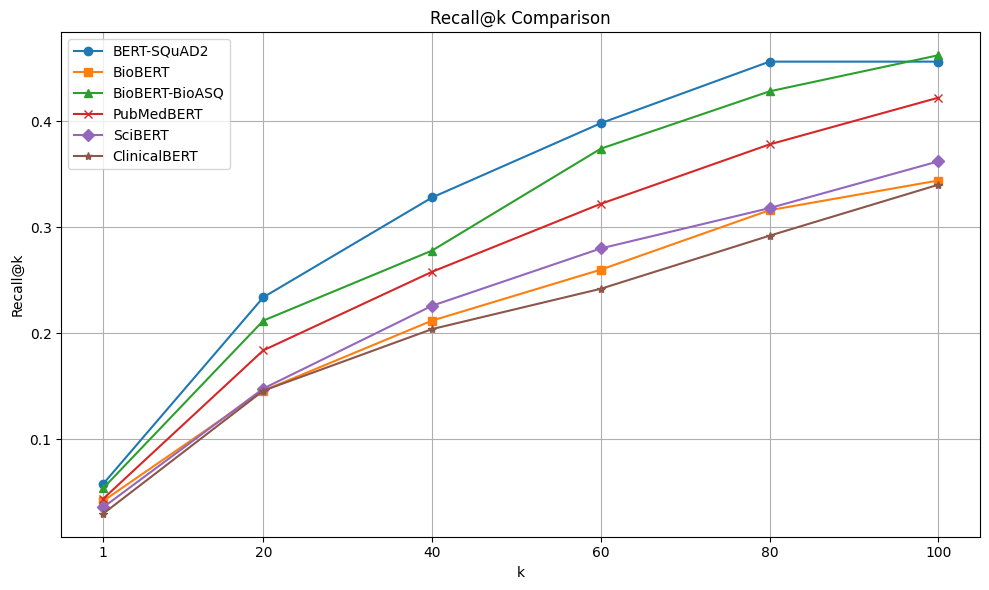

In [12]:
# Data
k_values = [1, 20, 40, 60, 80, 100]
bert_squad2 = [0.058, 0.234, 0.328, 0.398, 0.456, 0.456]
biobert = [0.042, 0.146, 0.212, 0.26, 0.316, 0.344]
biobert_bioasq = [0.0540, 0.2120, 0.2780, 0.3740, 0.4280, 0.4620]
pubmedbert = [0.0440, 0.1840, 0.2580, 0.3220, 0.3780, 0.4220]
scibert = [0.0360, 0.1480, 0.2260, 0.2800, 0.3180, 0.3620]
clinicalbert = [0.0300, 0.1460, 0.2040, 0.2420, 0.2920, 0.3400]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, bert_squad2, marker='o', label='BERT-SQuAD2')
plt.plot(k_values, biobert, marker='s', label='BioBERT')
plt.plot(k_values, biobert_bioasq, marker='^', label='BioBERT-BioASQ')
plt.plot(k_values, pubmedbert, marker='x', label='PubMedBERT')
plt.plot(k_values, scibert, marker='D', label='SciBERT')
plt.plot(k_values, clinicalbert, marker='*', label='ClinicalBERT')

plt.title('Recall@k Comparison')
plt.xlabel('k')
plt.ylabel('Recall@k')
plt.xticks(k_values)
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()


In [13]:
# Data for the models and their respective k values
k_values = [1, 20, 40, 60, 80, 100]
bert_squad2 = [0.058, 0.234, 0.328, 0.398, 0.456, 0.456]
biobert = [0.042, 0.146, 0.212, 0.26, 0.316, 0.344]
biobert_bioasq = [0.0540, 0.2120, 0.2780, 0.3740, 0.4280, 0.4620]
pubmedbert = [0.0440, 0.1840, 0.2580, 0.3220, 0.3780, 0.4220]
scibert = [0.0360, 0.1480, 0.2260, 0.2800, 0.3180, 0.3620]
clinicalbert = [0.0300, 0.1460, 0.2040, 0.2420, 0.2920, 0.3400]

# Create DataFrame
data = {
    'k': k_values,
    'BERT-SQuAD2': bert_squad2,
    'BioBERT': biobert,
    'BioBERT-BioASQ': biobert_bioasq,
    'PubMedBERT': pubmedbert,
    'SciBERT': scibert,
    'ClinicalBERT': clinicalbert
}

df = pd.DataFrame(data)

# Display the table
print(df)


     k  BERT-SQuAD2  BioBERT  BioBERT-BioASQ  PubMedBERT  SciBERT  \
0    1        0.058    0.042           0.054       0.044    0.036   
1   20        0.234    0.146           0.212       0.184    0.148   
2   40        0.328    0.212           0.278       0.258    0.226   
3   60        0.398    0.260           0.374       0.322    0.280   
4   80        0.456    0.316           0.428       0.378    0.318   
5  100        0.456    0.344           0.462       0.422    0.362   

   ClinicalBERT  
0         0.030  
1         0.146  
2         0.204  
3         0.242  
4         0.292  
5         0.340  


In [14]:
# Data for evaluation metrics
data = {
    'k': [1, 20, 40, 60, 80, 100],
    'Recall@k': [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    'Exact Match': [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
    'F1 Score': [0.0917, 0.1308, 0.1347, 0.1356, 0.1368, 0.1370]
}

# Creating a DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)


     k  Recall@k  Exact Match  F1 Score
0    1       0.0          0.0    0.0917
1   20       0.0          0.0    0.1308
2   40       0.0          0.0    0.1347
3   60       0.0          0.0    0.1356
4   80       0.0          0.0    0.1368
5  100       0.0          0.0    0.1370


In [15]:
# Data for the models
data = {
    'Model': ['ClinicalBERT', 'SciBERT', 'PubMedBERT', 'BioBERT-BioASQ', 'BioBERT', 'BERT-SQuAD2'],
    'Recall@1': [0.0300, 0.0360, 0.0440, 0.0540, 0.0420, 0.0580],
    'Average Exact Match (EM)': [0.2193, 0.2193, 0.2687, 0.3023, 0.2200, 0.2953],
    'Average F1 Score': [0.3508, 0.3508, 0.3488, 0.3968, 0.3462, 0.4298]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print(df)


            Model  Recall@1  Average Exact Match (EM)  Average F1 Score
0    ClinicalBERT     0.030                    0.2193            0.3508
1         SciBERT     0.036                    0.2193            0.3508
2      PubMedBERT     0.044                    0.2687            0.3488
3  BioBERT-BioASQ     0.054                    0.3023            0.3968
4         BioBERT     0.042                    0.2200            0.3462
5     BERT-SQuAD2     0.058                    0.2953            0.4298


In [16]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import time

# 1. Load data
corpus = pd.read_csv("data/training/sleep-corpus.tsv", sep="\t", header=None)
corpus.columns = ['index', 'passage', 'title']
test_qs = pd.read_csv("data/training/sleep-test.csv", sep="\t", header=None)
test_qs.columns = ['question', 'answer']

# 2. Define TF-IDF search function
def query_tfidf(question, vectorizer, tfidf_corpus, top_k=3):
    question_vec = vectorizer.transform([question])
    sims = cosine_similarity(question_vec, tfidf_corpus).flatten()
    top_indices = sims.argsort()[-top_k:][::-1]
    return [corpus.iloc[i]["passage"] for i in top_indices], sims[top_indices]

# 3. Define evaluation metrics
def evaluate_model(vectorizer, tfidf_corpus, test_df, ks=[1]):
    results = {}

    for k in ks:
        recall_at_k = []
        exact_match = []
        f1_scores = []

        for _, row in test_df.iterrows():
            question = row["question"]
            true_answer = row["answer"]

            retrieved_passages, _ = query_tfidf(question, vectorizer, tfidf_corpus, top_k=k)

            # Recall@k: if true answer appears in any retrieved passage
            match_found = any(true_answer.strip().lower() in passage.lower() for passage in retrieved_passages)
            recall_at_k.append(1 if match_found else 0)

            # Exact Match
            em = any(true_answer.strip().lower() == passage.strip().lower() for passage in retrieved_passages)
            exact_match.append(1 if em else 0)

            # F1 score (token level) with best candidate
            best_f1 = 0
            for passage in retrieved_passages:
                true_tokens = set(true_answer.lower().split())
                pred_tokens = set(passage.lower().split())
                common = true_tokens & pred_tokens
                if not common:
                    continue
                precision = len(common) / len(pred_tokens)
                recall = len(common) / len(true_tokens)
                f1 = 2 * precision * recall / (precision + recall)
                best_f1 = max(best_f1, f1)
            f1_scores.append(best_f1)

        # Store results for each k
        results[k] = {
            "Recall@k": np.mean(recall_at_k),
            "Exact Match": np.mean(exact_match),
            "F1 Score": np.mean(f1_scores)
        }

    return results

# 4. Evaluate TF-IDF Baseline Model
print("\n### Evaluating TF-IDF Baseline ###")
vectorizer = TfidfVectorizer()
tfidf_corpus = vectorizer.fit_transform(corpus["passage"].tolist())

# Evaluate the TF-IDF model
tfidf_metrics = evaluate_model(vectorizer, tfidf_corpus, test_qs, ks=[1, 20, 40, 60, 80, 100])

# 5. Final report
print("\n=================== Training Summary ===================")
print(f"Hyperparameters Used:")
print(f"- Batch Size: N/A (using simple TF-IDF retrieval)")
print(f"- Evaluation Metrics: Recall@k, Exact Match, F1 Score")

# Adjusted printing for nested dictionary
print(f"\nEvaluation Metrics for TF-IDF:")
for k, metrics in tfidf_metrics.items():
    print(f"\nFor k = {k}:")
    for metric_name, value in metrics.items():
        print(f"- {metric_name}: {value:.4f}")




### Evaluating TF-IDF Baseline ###

=================== Training Summary ===================
Hyperparameters Used:
- Batch Size: N/A (using simple TF-IDF retrieval)
- Evaluation Metrics: Recall@k, Exact Match, F1 Score

Evaluation Metrics for TF-IDF:

For k = 1:
- Recall@k: 0.0000
- Exact Match: 0.0000
- F1 Score: 0.0917

For k = 20:
- Recall@k: 0.0000
- Exact Match: 0.0000
- F1 Score: 0.1308

For k = 40:
- Recall@k: 0.0000
- Exact Match: 0.0000
- F1 Score: 0.1347

For k = 60:
- Recall@k: 0.0000
- Exact Match: 0.0000
- F1 Score: 0.1356

For k = 80:
- Recall@k: 0.0000
- Exact Match: 0.0000
- F1 Score: 0.1368

For k = 100:
- Recall@k: 0.0000
- Exact Match: 0.0000
- F1 Score: 0.1370
